Dưới đây là phần hướng dẫn song ngữ (🇬🇧 English - 🇻🇳 Vietnamese) giúp bạn xây dựng mô hình **QSAR** từ dữ liệu **IC50** trong **ChEMBL 35**, kết hợp với **RDKit** và phân tích trên **Jupyter Notebook** theo chuẩn **AIMLOps Template**.

---

## 🎯 Topic T1 – Building QSAR model from IC50 data in ChEMBL

### 🇻🇳 Chủ đề T1 – Xây dựng mô hình QSAR từ dữ liệu IC50 trong ChEMBL

---

## 🧪 1. Data Extraction from PostgreSQL (ChEMBL 35)

### 🇻🇳 1. Trích xuất dữ liệu từ PostgreSQL (ChEMBL 35)

### ✅ Mục tiêu / Goal:

* Lấy các phân tử có **giá trị IC50** hợp lệ.
* Lọc những giá trị là **số thật** và **< 100 µM** (có thể thay đổi).
* Xuất ra file `../data/T1_1_ic50_data.csv`.

---

### 📜 File SQL: `T1_1_extract_ic50_data.sql`

```sql
-- Get valid IC50 activity data
COPY (
    SELECT 
        md.chembl_id, 
        cs.canonical_smiles, 
        act.standard_value::float AS ic50,
        act.standard_type
    FROM activities act
    JOIN compound_structures cs ON act.molregno = cs.molregno
    JOIN molecule_dictionary md ON md.molregno = cs.molregno
    WHERE act.standard_type = 'IC50'
      AND act.standard_value IS NOT NULL
      AND act.standard_value ~ '^[0-9]+(\.[0-9]+)?$'  -- match numeric strings
      AND act.standard_value::float < 100
) TO '../data/T1_1_ic50_data.csv' WITH CSV HEADER;
```

> ❗ **Ghi chú lỗi**: Lỗi `operator does not exist: numeric ~ unknown` xảy ra do `standard_value` là kiểu `numeric`. Bạn phải ép kiểu về `text` trước khi áp dụng biểu thức chính quy. Nhưng vì bạn sau đó đã ép `::float`, có thể bỏ dòng `~` và thay bằng `TRY_CAST` nếu cần nâng cao. Ở đây dùng `~` kết hợp `::float`.

---

## 🧬 2. Molecular Descriptor Calculation using RDKit

### 🇻🇳 2. Tính toán các đặc trưng phân tử bằng RDKit

### ✅ Mục tiêu / Goal:

* Dùng SMILES để tính toán các đặc trưng như: MolWt, LogP, TPSA, NumHAcceptors,...
* Lưu lại dữ liệu đầy đủ để huấn luyện mô hình QSAR.

---

### 📓 File notebook: `T1_2_qsar_feature_engineering.ipynb`

```python
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Define path
base_path = os.path.abspath("..")
data_path = os.path.join(base_path, "data", "T1_1_ic50_data.csv")

# Load IC50 dataset
df = pd.read_csv(data_path)

# Convert SMILES to RDKit Mol objects
df['mol'] = df['canonical_smiles'].apply(Chem.MolFromSmiles)

# Compute molecular descriptors
df['MolWt'] = df['mol'].apply(Descriptors.MolWt)
df['LogP'] = df['mol'].apply(Descriptors.MolLogP)
df['TPSA'] = df['mol'].apply(Descriptors.TPSA)
df['NumHAcceptors'] = df['mol'].apply(Descriptors.NumHAcceptors)
df['NumHDonors'] = df['mol'].apply(Descriptors.NumHDonors)
df['RingCount'] = df['mol'].apply(Descriptors.RingCount)

# Drop invalid mols (None)
df = df[df['mol'].notna()]

# Save processed data
feature_path = os.path.join(base_path, "data", "T1_2_qsar_features.csv")
df.to_csv(feature_path, index=False)
```

---

## 📊 3. Build a Random Forest QSAR Model

### 🇻🇳 3. Xây dựng mô hình Random Forest dự đoán IC50

### 📓 File notebook: `T1_3_qsar_model_training.ipynb`

```python
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Load features
df = pd.read_csv(feature_path)

# Feature matrix and target
X = df[['MolWt', 'LogP', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'RingCount']]
y = df['ic50']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print(f"R² score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")
```

---

## 📁 Tóm tắt cấu trúc file theo chuẩn AIMLOps

### 🗂️ Folder structure summary (AIMLOps Style)

```
project_root/
│
├── data/
│   ├── T1_1_ic50_data.csv
│   └── T1_2_qsar_features.csv
│
├── notebook/
│   ├── T1_1_extract_ic50_data.sql         ← SQL truy vấn
│   ├── T1_2_qsar_feature_engineering.ipynb
│   └── T1_3_qsar_model_training.ipynb
│
├── src/
│   └── qsar_features.py                   ← nếu bạn gom các hàm tính toán
```

---

## 📌 Tổng kết / Summary:

| Bước  | Tiêu đề tiếng Việt        | English Title                 |
| ----- | ------------------------- | ----------------------------- |
| T1\_1 | Trích xuất IC50 từ ChEMBL | Extract IC50 from ChEMBL      |
| T1\_2 | Tính descriptor hóa học   | Compute molecular descriptors |
| T1\_3 | Huấn luyện mô hình QSAR   | Train QSAR prediction model   |

---

Bạn muốn tôi tiếp tục với:

* T1\_4: Biểu diễn trực quan kết quả?
* T1\_5: Tạo web app bằng Streamlit?
* T2\_x: Phân tích cho chủ đề mới?

Nếu bạn muốn ZIP lại toàn bộ ví dụ này hoặc xuất file `.ipynb`, tôi có thể tạo giúp bạn ngay.


In [7]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Define path
base_path = os.path.abspath("..")
# data_path = os.path.join(base_path, "data", "T1_1_ic50_data.csv")
data_path = os.path.join(base_path, "data", "ic50_dataset.csv")
# Load IC50 dataset
df = pd.read_csv(data_path)

# Convert SMILES to RDKit Mol objects
df['mol'] = df['canonical_smiles'].apply(Chem.MolFromSmiles)
a_path = os.path.join(base_path, "data", "ic50_data.csv")
# Compute molecular descriptors
df['MolWt'] = df['mol'].apply(Descriptors.MolWt)
df['LogP'] = df['mol'].apply(Descriptors.MolLogP)
df['TPSA'] = df['mol'].apply(Descriptors.TPSA)
df['NumHAcceptors'] = df['mol'].apply(Descriptors.NumHAcceptors)
df['NumHDonors'] = df['mol'].apply(Descriptors.NumHDonors)
df['RingCount'] = df['mol'].apply(Descriptors.RingCount)

# Drop invalid mols (None)
df = df[df['mol'].notna()]

# Save processed data
feature_path = os.path.join(base_path, "data", "T1_2_qsar_features.csv")
df.to_csv(feature_path, index=False)


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
# Load features
df = pd.read_csv(feature_path)

# Feature matrix and target
X = df[['MolWt', 'LogP', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'RingCount']]
y = df['ic50']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R² score: {r2_score(y_test, y_pred):.3f}")
# print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")
print(f"RMSE: {rmse:.3f}")

R² score: 0.132
RMSE: 1851.624


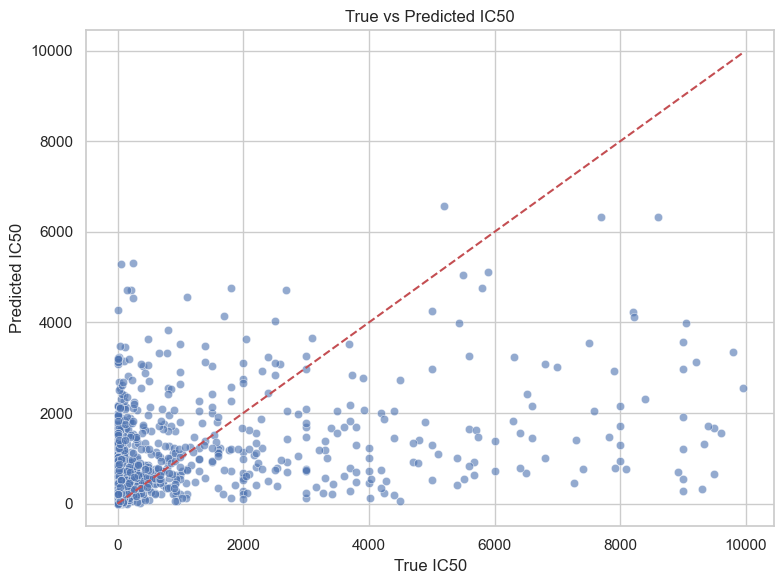

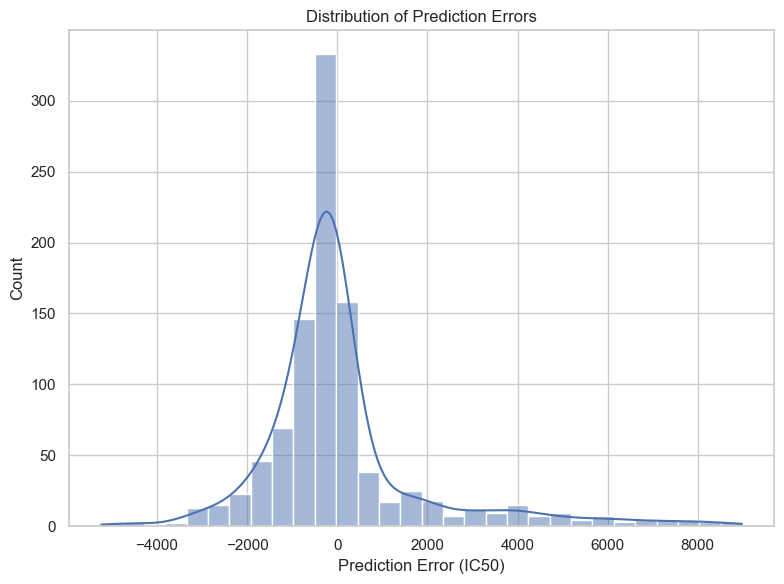

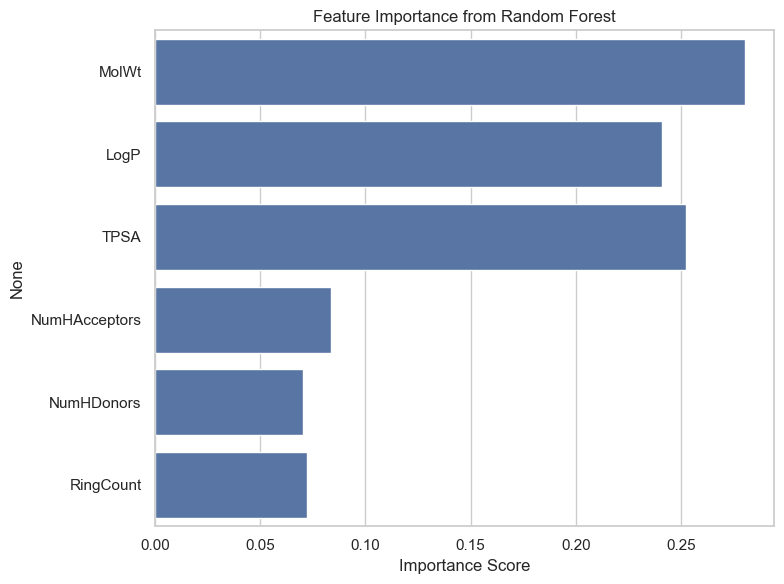

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đảm bảo vẽ đẹp
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# Giả sử bạn đã có model và dữ liệu từ T1_3
# Nếu không, hãy chạy lại đoạn dưới:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from joblib import dump, load

# Load lại dữ liệu
base_path = os.path.abspath("..")
feature_path = os.path.join(base_path, "data", "T1_2_qsar_features.csv")
df = pd.read_csv(feature_path)

X = df[['MolWt', 'LogP', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'RingCount']]
y = df['ic50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# --------- 🎯 1. Scatter plot: True vs Predicted ---------
plt.figure()
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("True IC50")
plt.ylabel("Predicted IC50")
plt.title("True vs Predicted IC50")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal
plt.tight_layout()
plt.savefig(os.path.join(base_path, "figures", "T1_4_true_vs_predicted.png"))
plt.show()

# --------- 🎯 2. Error Distribution ---------
errors = y_test - y_pred
plt.figure()
sns.histplot(errors, kde=True, bins=30)
plt.xlabel("Prediction Error (IC50)")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.savefig(os.path.join(base_path, "figures", "T1_4_prediction_error_distribution.png"))
plt.show()

# --------- 🎯 3. Feature Importance ---------
importances = model.feature_importances_
feature_names = X.columns

plt.figure()
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Importance Score")
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.savefig(os.path.join(base_path, "figures", "T1_4_feature_importance.png"))
plt.show()

In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from joblib import dump

# Define path
base_path = os.path.abspath("..")
data_path = os.path.join(base_path, "data", "T1_2_qsar_features.csv")
model_path = os.path.join(base_path, "model", "qsar_model.pkl")
os.makedirs(os.path.join(base_path, "model"), exist_ok=True)

# Load data
df = pd.read_csv(data_path)

# Define feature matrix X and target y
X = df[['MolWt', 'LogP', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'RingCount']]
y = df['ic50']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ R² score: {r2:.3f}")
print(f"✅ RMSE: {rmse:.3f}")

# Save model to file
dump(model, model_path)
print(f"✅ Model saved to: {model_path}")

✅ R² score: 0.132
✅ RMSE: 1851.624
✅ Model saved to: E:\DrugDev\CheMBL-35-100-Topics\model\qsar_model.pkl


In [16]:
import joblib
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# Load trained Random Forest model
model = joblib.load("../model/qsar_model.pkl")

# Input your SMILES
smiles = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"

In [17]:
# Convert SMILES to Mol object
mol = Chem.MolFromSmiles(smiles)

if mol is None:
    print("❌ Invalid SMILES")
else:
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'RingCount': Descriptors.RingCount(mol)
    }

    df = pd.DataFrame([descriptors])


In [18]:
pred_ic50 = model.predict(df)[0]
print(f"✅ Predicted IC50: {pred_ic50:.2f} µM")

✅ Predicted IC50: 1909.52 µM


In [20]:
import joblib
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# Load model
model = joblib.load("../model/qsar_model.pkl")

# Input SMILES
smiles = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"

mol = Chem.MolFromSmiles(smiles)

if mol is None:
    print("❌ Invalid SMILES")
else:
    desc = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'RingCount': Descriptors.RingCount(mol)
    }
    df = pd.DataFrame([desc])
    pred = model.predict(df)[0]
    print(f"✅ Predicted IC50: {pred:.2f} µM")

✅ Predicted IC50: 1909.52 µM
